# Displaying webcam video in IPython notebook at (relatively) high framerate

When working on my project I realized, I can use OpenCV in Python to grap image from webcam as Numpy array, modify it and then display it using OpenCV's **cv2.imshow()**. OpenCV will create a window and push my frame there. However, this will not work in a IPython notebook. I found few solutions to implement the same functionality, but they all were slow (about 250 ms per frame).

Here, I combine and modify these two examples to get achieve about 5 times higher framerate:
1. __[Showing webcame image using OpenCV and matplotlib](https://gist.github.com/tibaes/35b9dbd7cbf81a98955067aa318290e7#file-video)__. Important moment here is that previous frame is cleared from screen using **IPython.display.clear_output()**
2. __[Minimal code for rendering a numpy array as an image in a Jupyter notebook in memory](https://gist.github.com/kylemcdonald/2f1b9a255993bf9b2629)__. It uses PIL to convert NumPy array to .PNG format in order to display it with **IPython.display.display()**

Both are relatively slow. The slowest step in the first one is the __[matplotlib.pyplot.imshow()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html)__ and the second one spend most of the time converting array data to PNG in __[PIL.Image.save()](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.save)__.

But converting to PNG is not the fastest and only give me 2-3 FPS. If I use JPEG instead, framerate goes up to 36 FPS, which is not bad.

In [1]:
# Import the required modules
import cv2
import time
import numpy as np
import PIL.Image
from io import BytesIO
import IPython.display
import ipywidgets as widgets
import threading

In [2]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, prev_display_id=None, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if prev_display_id is not None:
        IPython.display.update_display(obj, display_id=prev_display_id)
        return prev_display_id
    else:
        return IPython.display.display(obj, display_id=True)

In [3]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    
    #flip image for natural viewing
#     frame = cv2.flip(frame, 1)
    
    return frame

In [4]:
def get_camera_indexes(max=10):
    # ref: https://stackoverflow.com/a/53310665/3553367
    arr = []
    for index in range(0, max):
#         print(index)
        cap = cv2.VideoCapture()
        cap.open(index)
        if cap.isOpened():
            arr.append(index)
        cap.release()
    return arr

In [5]:
camera_indexes = get_camera_indexes()

print(camera_indexes)

[0, 2]


Output()

FloatProgress(value=0.0, max=1.0)

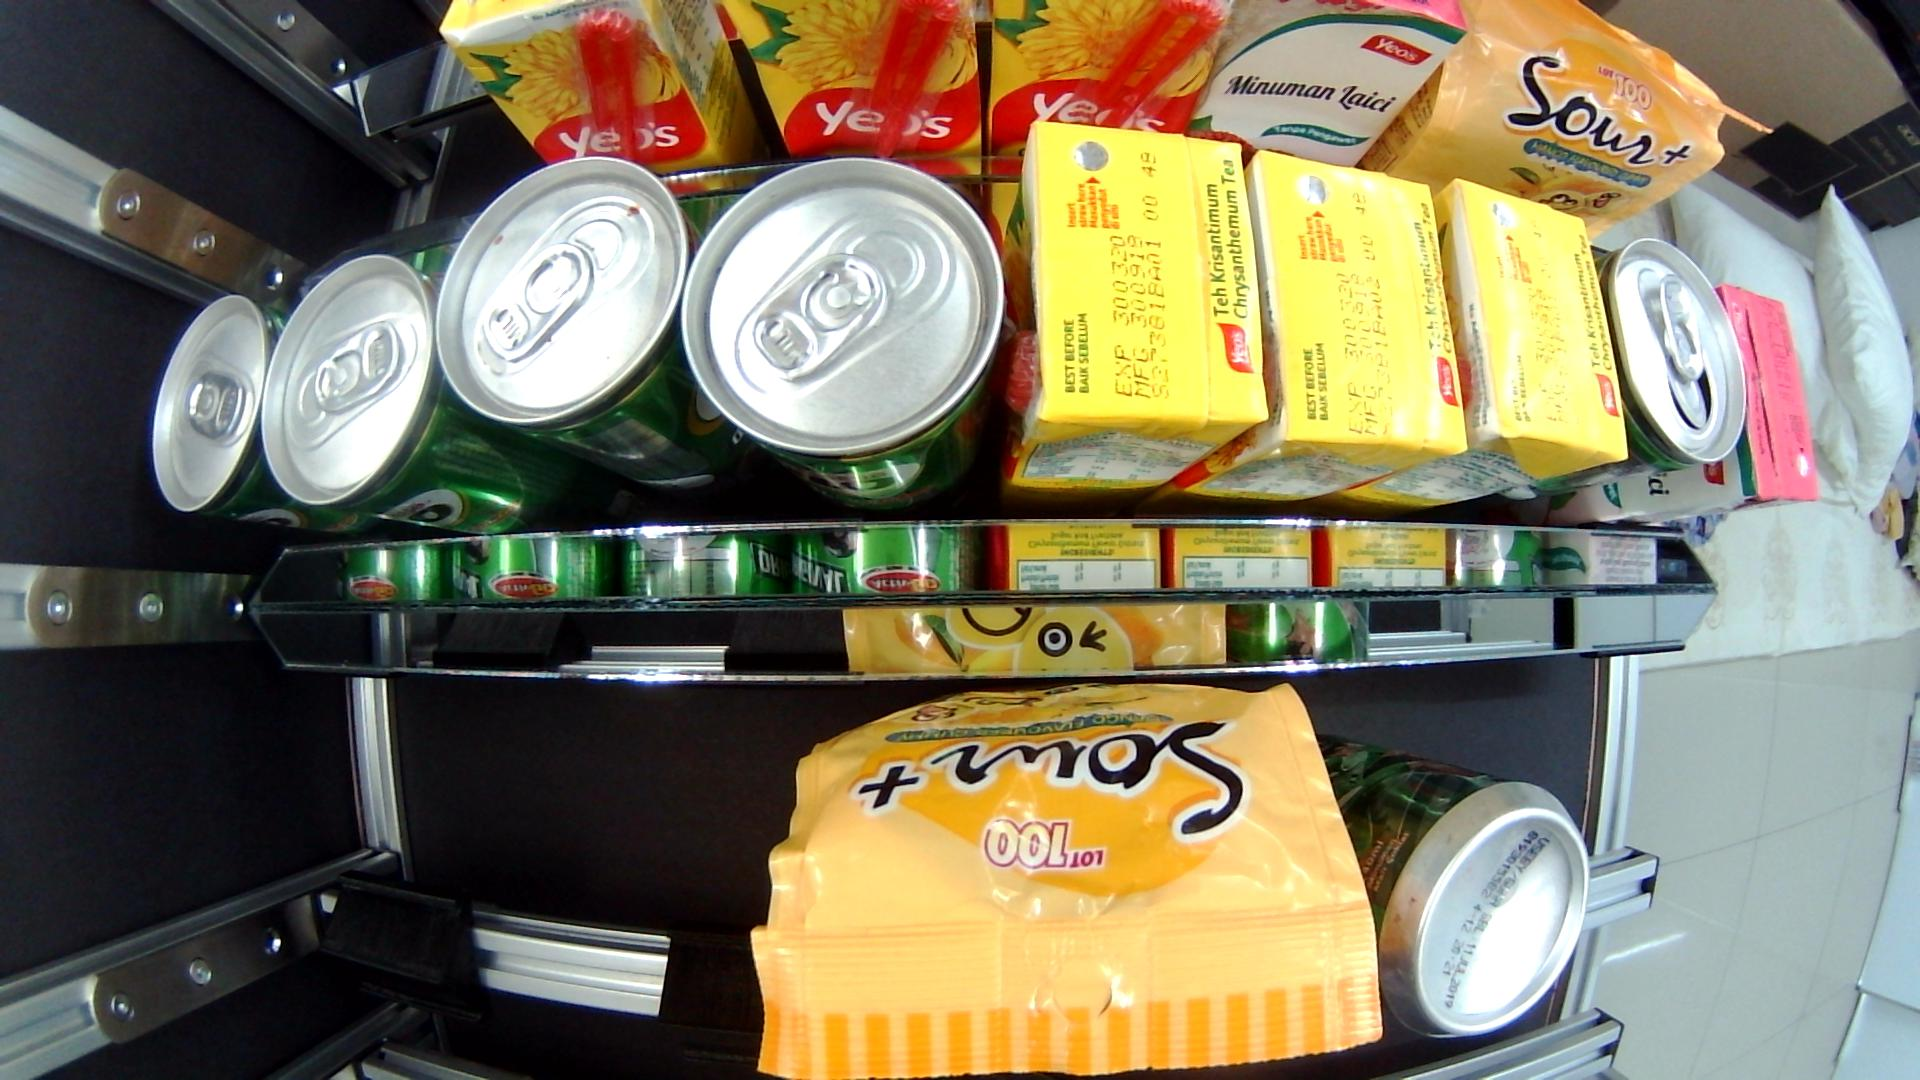

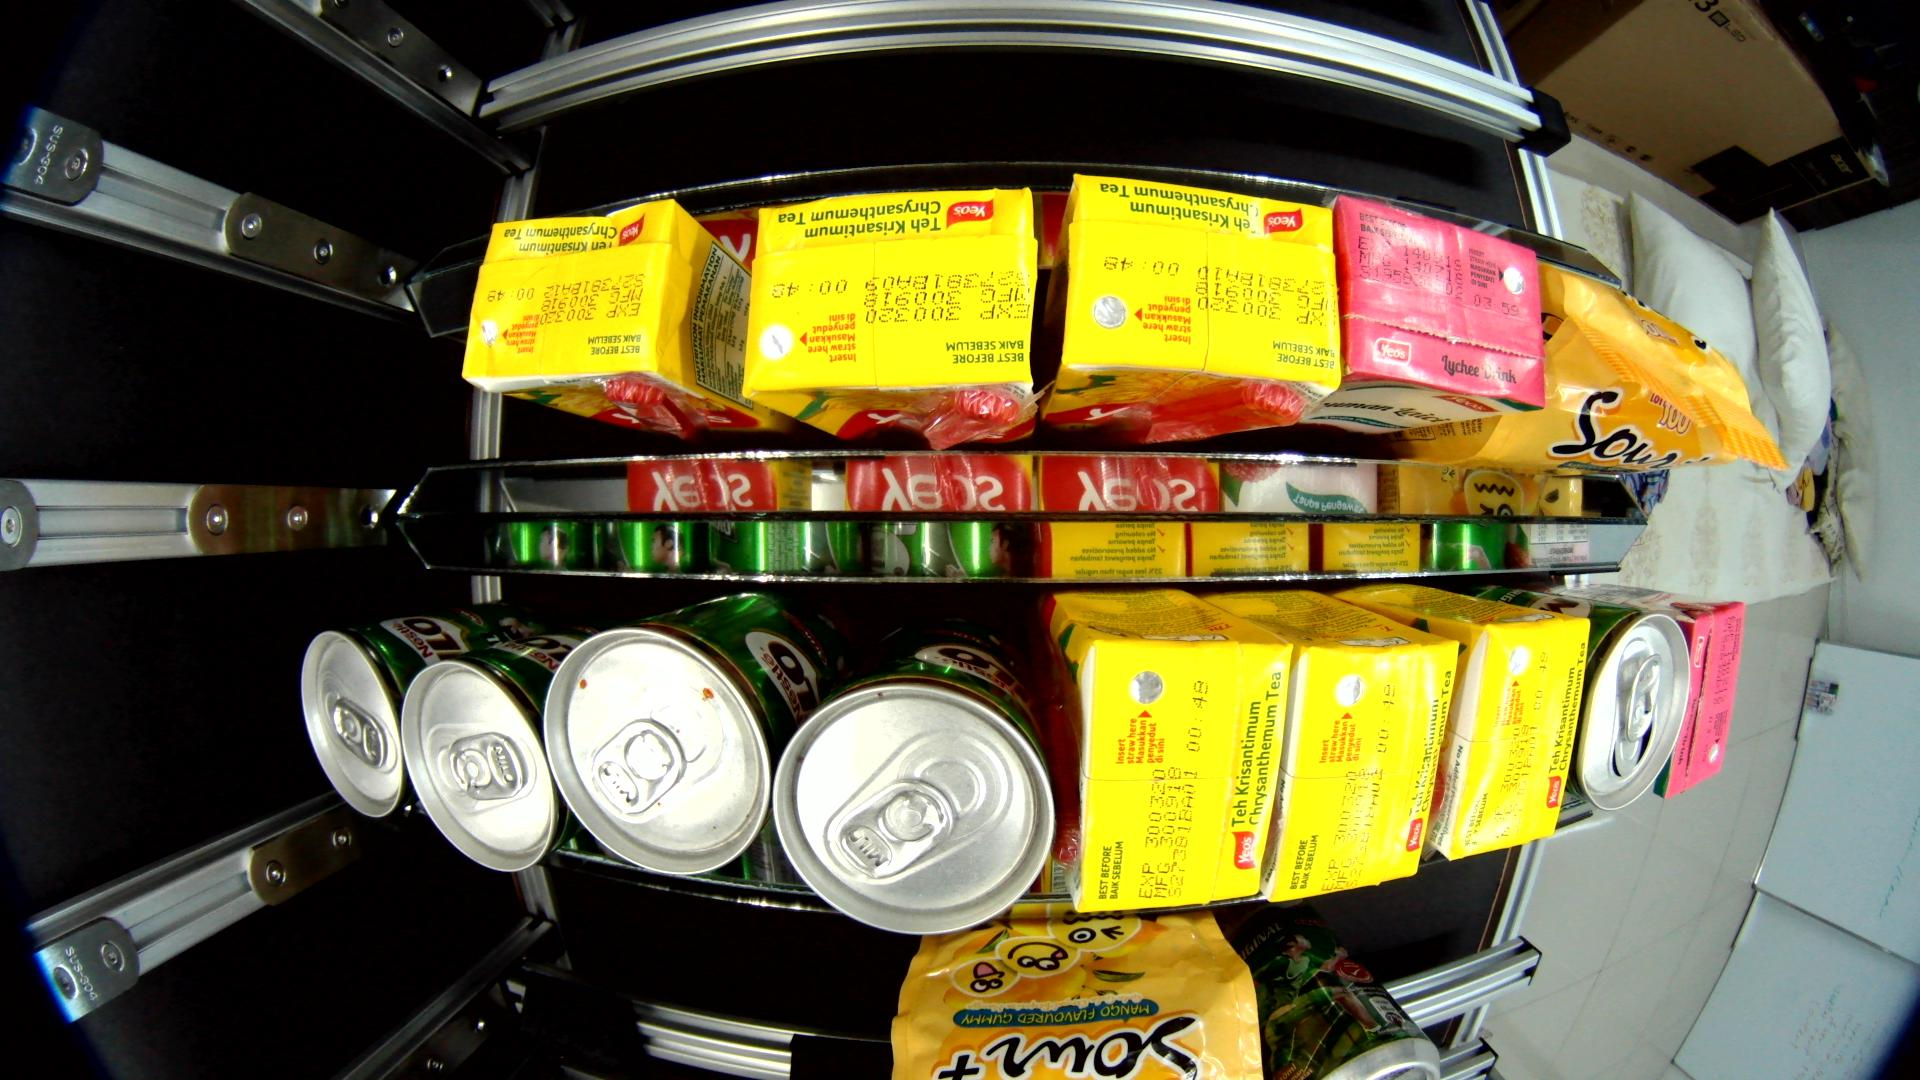

Stream stopped


In [6]:

total_cameras = len(camera_indexes)

cameras = []

for camera_index in camera_indexes:

    cam = cv2.VideoCapture(camera_index)


    # cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    # cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

#     cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1024)
#     cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1024

#     cam.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25) #ref: https://github.com/opencv/opencv/issues/9738#issuecomment-346584044
#     cam.set(cv2.CAP_PROP_EXPOSURE, 0.01)
#     cam.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0)
#     cam.set(cv2.CAP_PROP_EXPOSURE, -4.0)
    
    cameras.append({
        "camera_index": camera_index,
        'cam': cam,
        'display_id': None,
    })


frames_per_camera = 100

capture_image = False

fps_output = widgets.Output()
display(fps_output)

progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)

current_frame_number = 0

def work(progress):
    while current_frame_number is not frames_per_camera:
        time.sleep(1)
        progress.value = current_frame_number/frames_per_camera

thread = threading.Thread(target=work, args=(progress,))
display(progress)
thread.start()

for frame_number in range(1, frames_per_camera+1):
    current_frame_number = frame_number
    
    t1 = time.time()
        
    for camera_num, camera in enumerate(cameras):
        
        cam = camera.get('cam')

        # Capture frame-by-frame
        frame = get_frame(cam)

        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        display_id = camera.get('display_id')
#         print(camera)
        if display_id is not None:
            showarray(frame, display_id)
        else:
            display_handle = showarray(frame)
            camera['display_id'] = display_handle.display_id
            
        
    t2 = time.time()

    #ref: https://github.com/jupyter-widgets/ipywidgets/issues/1744#issuecomment-335179855
    with fps_output:
#         print("Camera: %d of %d" % (camera_num + 1, total_cameras))
        print("Frame: %d of %d" % (frame_number, frames_per_camera))

        print("%f FPS" % (1/(t2-t1)))
        # Display the frame info until new frame is available
        IPython.display.clear_output(wait=True)

        
for camera_index in camera_indexes:

    frame = get_frame(cam)
    cv2.imwrite('./captures/image'+str(camera_index)+'.jpg', frame) #need to create folder called captures first!
    cam.release()
    
print ("Stream stopped")